In [190]:
# this is a modification to Stan's code to extract PI from MOT2. 
# changes: 
# 1. it finds the metadata file and reads it, uses information in the metadata to plot and annotate outputs 
# 2. it finds the last 30 seconds of arousal test (assuming there is only one arousal test episode) and computes
# the PI of that period
# 3. it plots arousal PI grouped by and colored by user defined categories (but see notes near the bottom).
# 4. future versions will also include: statitc test PI; arousal test PI for multiple episodes as in trace cond. 
# 5. future versions will be wrapped nicely in functions. 
# windows users should change the direction of the slashes i think
import shutil


import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm as cm
import csv
import dabest
import seaborn as sns
%matplotlib inline

import os
currentPath = os.getcwd()
flagSwitchGenotype=False
##~~~~~~~~~~~~~~~~~ Windows users: Change the direction of slashes in the section below~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# the following line finds the sample data folder in the same folder as the code
# 2018-07-22-CS-Simultaneous-Green is an example of tests done with only CS files
# OK107Trace is an example of multiple sessions with 3 genotypes

datapath=currentPath+"/MOT2SampleData/"
# datapath=currentPath+"/MOT2SampleData/OK107Trace"

# # or user can define the path to data folder by uncommenting the following line
# datapath="/Users/xusy/Data/MOTSangyu/dump/2019-11-22_R58E02CasMS64Starved24hr"

datapath="/Users/xusy/Data/MOTSangyu/dump/2020-02-14_W1118Age/Age20Days"



experimentName=datapath.rsplit('/', 1)[-1]
if 1*("summary" in os.listdir(datapath))==0:
    os.mkdir(datapath + '/summary')
summaryFolderPath=datapath + '/summary/'
##~~~~~~~~~~~~~~~~~ Windows users: Change the direction of slashes in the section above~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

print (datapath)
filenames = os.listdir(datapath)
filenames.sort()
#finds the countlogs here
countlogs= [s for s in filenames if "CountLog" in s]
#finds the metadata files here
metadatas = [s for s in filenames if "MetaData" in s]
PeriodToAnalyse=30
PIdfAllDay=[];
minStaticTestIndex=1
startingChamberNumber=5
#proceses each countlog in alphabetical
for i in range(0, len(countlogs)):
    f = countlogs[i]
    m = 'MetaData'+ f[8:]
    df = pd.read_csv(datapath+'/'+f, error_bad_lines=False)
    dfMeta = pd.read_csv(datapath+'/'+m, error_bad_lines=False)
    shutil.copyfile(datapath+'/'+f, summaryFolderPath +'Countlog' + f[8:-4]+ '_anti' + dfMeta.loc[5, 'Odor'] + '_' + dfMeta.loc[5, 'Genotype']+ '.csv')
    #finds the bits in the countlogs that are arousal tests
    arousalTestIndex=[i for i, e in enumerate(df.ExperimentState) if "Arousal" in e]
    #picks out the last 30 data points (which at 1fps is 30 seconds) in future versions this should be made a function of framerate
    lastArousalTime = df.loc[arousalTestIndex[-1]].Seconds-PeriodToAnalyse
    absDiffArousalTime = np.absolute(df.loc[arousalTestIndex].Seconds-lastArousalTime)
    start30SecondArousalIdx = absDiffArousalTime.idxmin(skipna=True)
    last30secArousal = df.loc[start30SecondArousalIdx: arousalTestIndex[-1]]
    PIArousalAll=last30secArousal.filter(regex= "Ch"+str(startingChamberNumber+1)+"_PI_r")
    SpeedArousalAll=last30secArousal.filter(regex= "Ch"+str(startingChamberNumber+1)+"_Vpix/s")

    
    for chamber in range(startingChamberNumber+1, 15):
        last30secArousalDF = last30secArousal.filter(regex= "Ch"+str(chamber)+"_PI_r")
        PIArousalAll["Ch"+str(chamber)+"_PI_r"] =last30secArousalDF.values  
        SpeedArousalAll=last30secArousal.filter(regex= "_Vpix/s").values
        


    PIallArousalAverage = PIArousalAll.mean(axis=0)
    PIallArousalAverage.values[np.flatnonzero(1*dfMeta.Odor[startingChamberNumber:15]=='MCH')] = 0- PIallArousalAverage.values[np.flatnonzero(1*dfMeta.Odor[startingChamberNumber:15]=='MCH')]

    GenotypeList=['Control Gal4', 'Control UAS', 'Test', 'CS']
    GenotypeNumber = 1*dfMeta.Genotype.str.contains('Gal4')+2*dfMeta.Genotype.str.contains('UAS')+4*dfMeta.Genotype.str.contains('CS')    
    PIresults={'Chambers':np.arange(startingChamberNumber+1,15), 'Run':str(i+1), 'Odor':dfMeta.Odor[startingChamberNumber:15],
               'Corrected Arousal PI':PIallArousalAverage.values.T,  'Set':dfMeta.Set[startingChamberNumber:15],
               'Genotype':dfMeta.Genotype[startingChamberNumber:15], 'GenotypeNumber':GenotypeNumber[startingChamberNumber:15]}

    #finds the bits in the countlogs that are arousal tests
    staticTestIndex=[i for i, e in enumerate(df.ExperimentState) if "Static" in e]
    if len(staticTestIndex) !=0:
        #picks out the last 30 data points (which at 1fps is 30 seconds) in future versions this should be made a function of framerate
        last30secStatic = df.loc[staticTestIndex[-PeriodToAnalyse:]]
        lastStaticTime = df.loc[staticTestIndex[-1]].Seconds-PeriodToAnalyse
        absDiffStaticTime = np.absolute(df.loc[staticTestIndex].Seconds-lastStaticTime)
        start30SecondStaticIdx = absDiffStaticTime.idxmin(skipna=True)
        last30secArousal = df.loc[start30SecondStaticIdx: staticTestIndex[-1]]
        PIStaticAll=last30secStatic.filter(regex= "Ch"+str(startingChamberNumber+1)+"_PI_r")

        for chamber in range(startingChamberNumber+1, 15):        
            last30secStaticDF = last30secStatic.filter(regex= "Ch"+str(chamber)+"_PI_r")
            PIStaticAll["Ch"+str(chamber)+"_PI_r"] =last30secStaticDF.values
        PIallStaticAverage = PIStaticAll.mean(axis=0)
        PIallStaticAverage.values[np.flatnonzero(1*dfMeta.Odor[startingChamberNumber:15]=='MCH')] = 0- PIallStaticAverage.values[np.flatnonzero(1*dfMeta.Odor[startingChamberNumber:15]=='MCH')]
        PIresults={'Chambers':np.arange(startingChamberNumber+1,15), 'Run':str(i+1), 'Odor':dfMeta.Odor[startingChamberNumber:15],
               'Corrected Arousal PI':PIallArousalAverage.values.T, 'Set':dfMeta.Set[startingChamberNumber:15],
               'Genotype':dfMeta.Genotype[startingChamberNumber:15], 'GenotypeNumber':GenotypeNumber[startingChamberNumber:15], 'Corrected Static PI':PIallStaticAverage.values.T}
    PIdf=pd.DataFrame(data=PIresults)
    PIdf.index=range(1, len(PIdf)+1)
    GenotypeCorrected=[GenotypeList[PIdf.loc[i].GenotypeNumber-1] for i in range(1, len(PIdf)+1)]
    PIdf=PIdf.assign(GenotypeCorrected = GenotypeCorrected)        
    PIdf=PIdf.drop(['GenotypeNumber'], axis=1)
    # the following lines save the average and raw PIs as .csv into a folder called 'summary' created in the original data folder
    PIdf.to_csv(summaryFolderPath + 'averagePI' + f[8:-4] + '.csv', sep=',', index=True, index_label = None)
    PIArousalAll.to_csv(summaryFolderPath + 'arousalRawPI'+ f[8:-4] + '.csv', sep=',', index=True)
    if len(staticTestIndex) !=0:
        PIStaticAll.to_csv(summaryFolderPath + 'staticRawPI'+ f[8:-4] + '.csv', sep=',', index=True)
    PIdfAllDay.append(PIdf)
    print(f)
    print(PIdf)
    print('Mean PI' + str(np.mean(PIallArousalAverage.values.T)))
    minStaticTestIndex = np.min([minStaticTestIndex, len(staticTestIndex)])
PIdfAllDay=pd.concat(PIdfAllDay)
PIdfAllDay.index=range(1, len(PIdfAllDay)+1)

Sets=np.unique(PIdfAllDay.Set)
FullPIAllDay=[];
uniqueSets=np.unique(PIdfAllDay.Set)
uniqueOdors=np.unique(PIdfAllDay.Odor)

if len(uniqueOdors)==2:
    for s in uniqueSets:
        PIdfAllDaySet=PIdfAllDay.loc[PIdfAllDay.Set==s]
        FullPIdf=PIdfAllDaySet[0:len(PIdf)]
        FullPIdf['Full Arousal PI']=(PIdfAllDaySet['Corrected Arousal PI'][0:len(PIdf)].values+PIdfAllDaySet['Corrected Arousal PI'][len(PIdf):len(PIdf)*2].values)/2
        FullPIdf['Full Static PI']=(PIdfAllDaySet['Corrected Static PI'][0:len(PIdf)].values+PIdfAllDaySet['Corrected Static PI'][len(PIdf):len(PIdf)*2].values)/2
        FullPIdf=FullPIdf.drop(['Corrected Static PI', 'Corrected Arousal PI'], axis=1)
        FullPIdf['Odor']='Full'
        FullPIAllDay.append(FullPIdf)
FullPIAllDay=pd.concat(FullPIAllDay)
FullPIAllDay.index=range(1, len(FullPIAllDay)+1)
FullPIAllDay.Set=FullPIAllDay.Set.astype(int)
FullPIAllDay.Set=FullPIAllDay.Set.astype(str)





/Users/xusy/Data/MOTSangyu/dump/2020-02-14_W1118Age/Age20Days


/Users/xusy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/xusy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


CountLog_2020-02-14_15-49-41.csv
   Chambers Run Odor  Corrected Arousal PI  Set   Genotype  \
1         6   1  OCT              0.600194  2.0  W1118-20d   
2         7   1  OCT              0.214000  2.0  W1118-20d   
3         8   1  OCT             -0.333000  2.0  W1118-20d   
4         9   1  OCT              0.561226  2.0  W1118-20d   
5        10   1  OCT              0.254839  2.0  W1118-20d   
6        11   1  OCT              0.658226  2.0  W1118-20d   
7        12   1  OCT              0.600000  2.0  W1118-20d   
8        13   1  OCT              0.648677  2.0  W1118-20d   
9        14   1  OCT              0.470968  2.0  W1118-20d   

   Corrected Static PI GenotypeCorrected  
1            -0.593333                CS  
2            -0.531100                CS  
3            -0.310800                CS  
4            -0.186667                CS  
5             0.540000                CS  
6             0.275533                CS  
7            -0.197767                CS  
8 

/Users/xusy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/xusy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


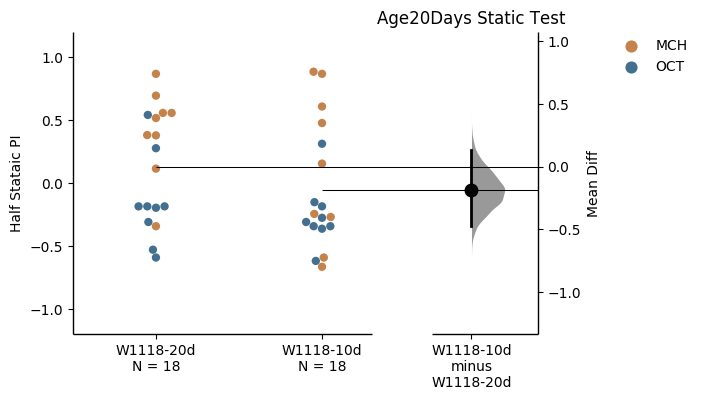

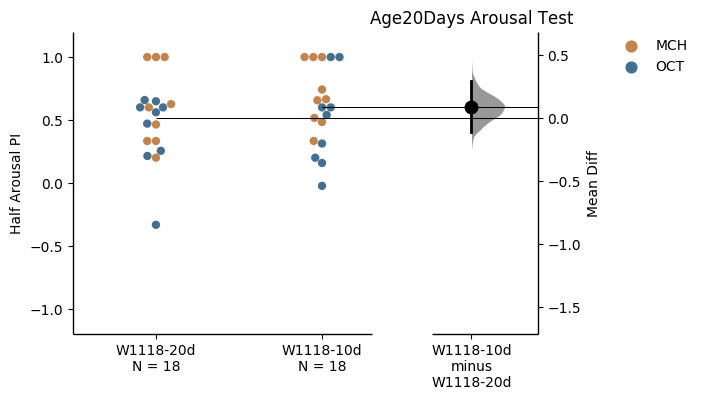

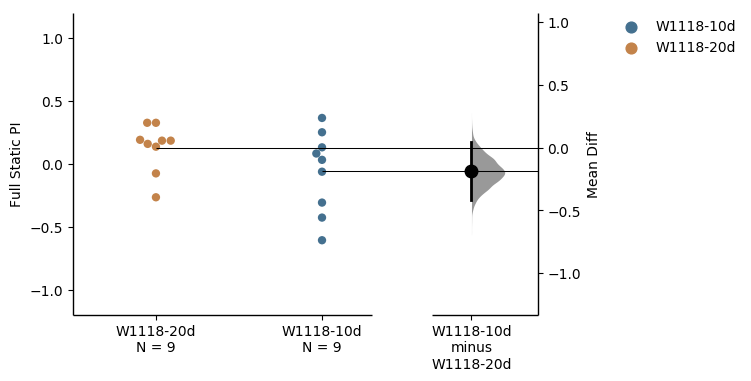

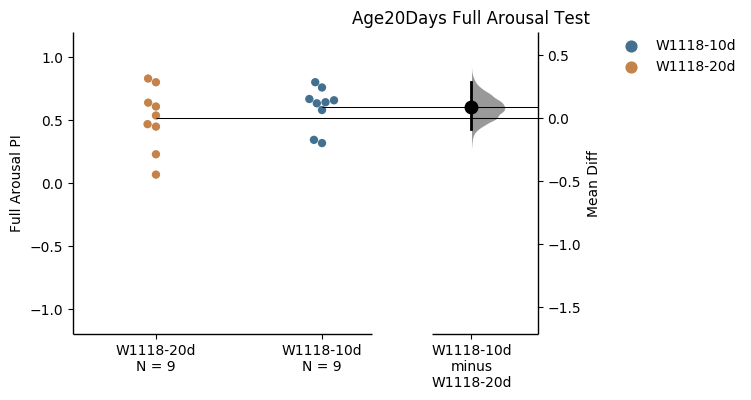

In [191]:


plt.figure
    
PIdfAllDay['Status']=PIdfAllDay.GenotypeCorrected
PIdfAllDay.loc[PIdfAllDay.GenotypeCorrected == 'Control Gal4', 'Status']='Sibling'
PIdfAllDay.loc[PIdfAllDay.GenotypeCorrected == 'Control UAS', 'Status']='Sibling'
PIdfAllDay.loc[PIdfAllDay.GenotypeCorrected == 'Test', 'Status']='Offspring'

 
PIdfAllDay1=PIdfAllDay

# PIdfAllDay1=PIdfAllDay.loc[PIdfAllDay.Genotype!='W1118']
# PIdfAllDay1=PIdfAllDay1.loc[PIdfAllDay1.Odor=='OCT']
PIdfAllDay1=PIdfAllDay1.reset_index()



uniqueGenotypeIdx=np.unique(PIdfAllDay1.Genotype, return_index=True)[1]
GenotypeLabels=[PIdfAllDay1.loc[j+1].Genotype for j in uniqueGenotypeIdx]



if flagSwitchGenotype:
    uniqueGenotypeIdx=np.unique(PIdfAllDay1.GenotypeCorrected, return_index=True)[1]
    GenotypeLabels=[PIdfAllDay1.loc[j+1].GenotypeCorrected for j in uniqueGenotypeIdx]
    genotypeToUse='GenotypeCorrected'
else:
    
    GenotypeLabels=np.sort(GenotypeLabels)[::-1]
    genotypeToUse='Genotype'

uniqueRunIdx=np.unique(PIdfAllDay1.Run, return_index=True)[1]
RunLabels=[PIdfAllDay1.loc[k+1].Run for k in uniqueRunIdx]
uniqueOdorIdx=np.unique(PIdfAllDay1.Odor, return_index=True)[1]
odorLabels=[PIdfAllDay1.loc[j+1].Odor for j in uniqueOdorIdx]
# uniqueSetIdx=np.unique(FullPIAllDay.Set, return_index=True)
# setLabels=[FullPIAllDay.loc[j].Set for j in uniqueOdorIdx]






if minStaticTestIndex !=0:
    if len(GenotypeLabels)>1: # if there are different genotypes in the metadata, more commonly encountered in tests        
        StaticB = dabest.load(PIdfAllDay1,
                           x=genotypeToUse, # the default for this test config is to group flies by genotype
                           y='Corrected Static PI',
                           idx=GenotypeLabels,
                           paired=False
                          )
    
        fStaticB = StaticB.mean_diff.plot(                            
                            swarm_label='Half Stataic PI',
                            contrast_label='Mean Diff',


                           color_col='Odor',# and color by odor
                           swarm_ylim =(-1.2,1.2),
                           fig_size=(6,4))


    else: # if there is only one genotype in the metadata, commonly encountered if just test equipment with CS flies

        StaticB = dabest.load(PIdfAllDay1,
                           x='Odor', # the default for this test config is to group flies by genotype
                           y='Corrected Static PI',
                           idx=odorLabels,
                           paired=False
                          )
    
        fStaticB = StaticB.mean_diff.plot(
                            swarm_label='Half Static PI',
                            contrast_label='Mean Diff',


                           color_col='Odor',# and color by odor
                           swarm_ylim =(-1.2,1.2),

                           fig_size=(6,4))


    # print(b)
    plt.title(experimentName + ' Static Test')   
    plt.savefig(summaryFolderPath+ 'StaticContrast' + f[8:-4] + '.png', bbox_inches='tight', dpi = 300)

    
    
if len(GenotypeLabels)>1: # if there are different genotypes in the metadata, more commonly encountered in tests
    ArousalB = dabest.load(PIdfAllDay1,
                           x=genotypeToUse, # the default for this test config is to group flies by genotype
                           y='Corrected Arousal PI',
                           idx=GenotypeLabels,
                           paired=False
                          )
    
    fAraousalB = ArousalB.mean_diff.plot(
                           swarm_label='Half Arousal PI',
                        contrast_label='Mean Diff',


                           color_col='Odor',# and color by odor
                           swarm_ylim =(-1.2,1.2),

                           fig_size=(6,4))
else: # if there is only one genotype in the metadata, commonly encountered if just test equipment with CS flies
    ArousalB = dabest.load(PIdfAllDay1,
                           x='Odor', # if just one type of flies, group by odor. This can also be "Run" 
                                      #which is the session/file in chronological sequence
                           y='Corrected Arousal PI',
                           idx=odorLabels, # this has to correspond to the value of x above. if x is 'Run', idx has to be 'RunLabels'
                           paired=False
                          )
    
    fArousalB = ArousalB.mean_diff.plot(
                          swarm_label='Half Arousal PI',
                        contrast_label='Mean Diff',
                            color_col='Odor',# and color by odor
                           swarm_ylim =(-1.2,1.2),

                           fig_size=(6,4))
    
    
plt.title(experimentName + ' Arousal Test')   
# print(b)
# the following line saves the figure into a folder called 'summary' created in the original data folder
plt.savefig(summaryFolderPath+ 'ArousalContrast' + f[8:-4] + '.png', bbox_inches='tight', dpi = 300)
PIdfAllDay.to_csv(summaryFolderPath + 'PIdfAllDay'+ f[8:-4] + '.csv', sep=',', index=True)



    
FullPIAllDay['Status']=FullPIAllDay.GenotypeCorrected
FullPIAllDay.loc[FullPIAllDay.GenotypeCorrected == 'Control Gal4', 'Status']='Sibling'
FullPIAllDay.loc[FullPIAllDay.GenotypeCorrected == 'Control UAS', 'Status']='Sibling'
FullPIAllDay.loc[FullPIAllDay.GenotypeCorrected == 'Test', 'Status']='Offspring'



if minStaticTestIndex !=0:
    if len(GenotypeLabels)>1: # if there are different genotypes in the metadata, more commonly encountered in tests        
        StaticF = dabest.load(FullPIAllDay,
                           x='Genotype', # the default for this test config is to group flies by genotype
                           y='Full Static PI',
                           idx=GenotypeLabels,
                           paired=False
                          )
    
        fStaticF = StaticF.mean_diff.plot(
                          swarm_label='Full Static PI',
                        contrast_label='Mean Diff',
                           color_col='Genotype',# and color by odor
                           swarm_ylim =(-1.2,1.2),

                           fig_size=(6,4))


    else: # if there is only one genotype in the metadata, commonly encountered if just test equipment with CS flies

        StaticF = dabest.load(FullPIAllDay,
                           x='Set', # the default for this test config is to group flies by genotype
                           y='Full Static PI',
                           idx=setLabels,
                           paired=False
                          )
    
        fStaticF = StaticF.mean_diff.plot(
                          swarm_label='Full Static PI',
                        contrast_label='Mean Diff',

                           color_col='Set',# and color by odor
                           swarm_ylim =(-1.2,1.2),

                           fig_size=(6,4))
else: 

    # print(b)
    plt.title(experimentName + ' Full Static Test')   
    plt.savefig(summaryFolderPath+ 'FullPIStaticContrast' + f[8:-4] + '.png', bbox_inches='tight', dpi = 300)


if len(GenotypeLabels)>1: # if there are different genotypes in the metadata, more commonly encountered in tests
    ArousalF = dabest.load(FullPIAllDay,
                           x='Genotype', # the default for this test config is to group flies by genotype
                           y='Full Arousal PI',
                           idx=GenotypeLabels,
                           paired=False
                          )
    
    fAraousalF = ArousalF.mean_diff.plot(
        
                           swarm_label='Full Arousal PI',
                        contrast_label='Mean Diff',

                          color_col='Genotype',# and color by odor
                           swarm_ylim =(-1.2,1.2),

                           fig_size=(6,4))
else: # if there is only one genotype in the metadata, commonly encountered if just test equipment with CS flies
    ArousalF = dabest.load(FullPIAllDay,
                           x='Set', # if just one type of flies, group by odor. This can also be "Run" 
                                      #which is the session/file in chronological sequence
                           y='Full Arousal PI',
                           idx=setLabels, # this has to correspond to the value of x above. if x is 'Run', idx has to be 'RunLabels'
                           paired=False
                          )
    
    fArousalF = ArousalF.mean_diff.plot(
                           swarm_label='Full Arousal PI',
                        contrast_label='Mean Diff',

                            color_col='Set',# and color by odor
                           swarm_ylim =(-1.2,1.2),

                           fig_size=(6,4))
    
    
plt.title(experimentName + ' Full Arousal Test')   
# print(b)
# the following line saves the figure into a folder called 'summary' created in the original data folder
plt.savefig(summaryFolderPath+ 'FullPIArousalContrast' + f[8:-4] + '.png', bbox_inches='tight', dpi = 300)
PIdfAllDay.to_csv(summaryFolderPath + 'FullPIAllDay'+ f[8:-4] + '.csv', sep=',', index=True)



In [189]:
FullPIAllDay

,Chambers,Run,Odor,Set,Genotype,GenotypeCorrected,Full Arousal PI,Full Static PI,Status
1,6,1,Full,1,W1118-20d,CS,0.466597,0.136667,CS
2,7,1,Full,1,W1118-20d,CS,0.607000,-0.075550,CS
3,8,1,Full,1,W1118-20d,CS,0.065758,0.191267,CS
4,9,1,Full,1,W1118-20d,CS,0.447113,0.184600,CS
5,10,1,Full,1,W1118-20d,CS,0.227419,0.326633,CS
6,11,1,Full,1,W1118-20d,CS,0.829113,0.326500,CS
7,12,1,Full,1,W1118-20d,CS,0.800000,0.158900,CS
8,13,1,Full,1,W1118-20d,CS,0.637306,-0.265400,CS
9,14,1,Full,1,W1118-20d,CS,0.535484,0.184600,CS


In [173]:
FullPIAllDay.loc[FullPIAllDay.GenotypeCorrected == 'Control Gal4', 'Status']='Sibling'

FullPIAllDay.loc[FullPIAllDay.GenotypeCorrected == 'Control UAS', 'Status']='Sibling'

FullPIAllDay.loc[FullPIAllDay.GenotypeCorrected == 'Test', 'Status']='Offspring'


FullPIAllDay

,Chambers,Run,Odor,Set,Genotype,GenotypeCorrected,Full Arousal PI,Full Static PI,Status
1,6,1,Full,1,W1118; UAS-ACR1,Control UAS,0.696016,0.619850,Sibling
2,7,1,Full,1,W1118; UAS-ACR1,Control UAS,0.478097,0.562100,Sibling
3,8,1,Full,1,W1118; UAS-ACR1,Control UAS,0.789290,-0.048367,Sibling
4,9,1,Full,1,W1118; UAS-ACR1,Control UAS,0.799548,0.430000,Sibling
5,10,1,Full,1,W1118; UAS-ACR1,Control UAS,0.832258,0.010950,Sibling
6,11,1,Full,1,W1118; UAS-ACR1,Control UAS,0.864516,0.510000,Sibling
7,12,1,Full,1,W1118; UAS-ACR1,Control UAS,0.645048,0.769783,Sibling
8,13,1,Full,1,W1118; UAS-ACR1,Control UAS,0.222581,0.604033,Sibling
9,14,1,Full,1,W1118; UAS-ACR1,Control UAS,0.842597,0.630983,Sibling
10,6,2,Full,2,Trh-Gal4; UAS-ACR1,Test,-0.266129,0.311683,Offspring


In [174]:
uniqueSetIdx=np.unique(FullPIAllDay.Set, return_index=True)
# setLabels=[FullPIAllDay.loc[j+1].Set for j in uniqueOdorIdx]
uniqueSetIdx


(array(['1', '2', '3'], dtype=object), array([ 0,  9, 18]))

In [175]:
Static = dabest.load(FullPI,
                           x='Status', # the default for this test config is to group flies by genotype
                           y='Full Static PI',
                           idx=['Sibling', 'Offspring'],
                           paired=False
                          )
    
fStatic = Static.mean_diff.plot(
                           color_col='Genotype',# and color by odor
                           swarm_ylim =(-1.5,1.5),
                           fig_size=(4,6))

Arousal = dabest.load(FullPI,
                           x='Status', # the default for this test config is to group flies by genotype
                           y='Full Arousal PI',
                           idx=['Sibling', 'Offspring'],
                           paired=False
                          )
    
fArousal = Arousal.mean_diff.plot(
                           color_col='Genotype',# and color by odor
                           swarm_ylim =(-1.5,1.5),
                           fig_size=(4,6))




NameError: name 'FullPI' is not defined

In [ ]:

FullPIAllDay[0]

In [ ]:
uniqueGenotypeIdx

In [ ]:
uniqueGenotypeIdx=np.unique(PIdfAllDay1.Genotype, return_index=True)[1]

In [ ]:
uniqueGenotypeIdx